In [13]:
import sys
import tensorflow as tf
import keras
from keras.models import Model, load_model
from keras.callbacks import EarlyStopping
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras import optimizers
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras import backend as K

from sklearn.metrics import confusion_matrix
import itertools

from tqdm import tqdm

In [2]:
width = 50
height = 10
channels = 3
classes = 4
dataset_dir = '/data/user/adipilat/ParticleID/genEvts/'
save_dir = '/data/user/adipilat/ParticleID/models/'
plot_dir = '/data/user/adipilat/ParticleID/plots/'
padding = 'padding' + str(height)
model_name= padding +'_model'
history_name = padding + '_history'


# This dictionary should be extended to new classes and antiparticles
class_labels = {22:0, 11:1, 13:2, 211:3}

class_names = np.array(['gamma', 'electron', 'muon', 'pion_c'])

In [3]:
# arrays of data needed for training

data_array = []
pid_array = []
en_array = []

# read dataset
files = [f for f in os.listdir(dataset_dir) if f.endswith("h5")]

for name in tqdm(files):
    print("Reading file", name)
    data = pd.read_hdf(dataset_dir + name)

    # using 10% of events for test
    n_events_start = int(0.9 * data.event.max()) 
    n_events = int(data.event.max())
    
    for i in range(n_events_start+1, n_events+1):
        tracksters = data.loc[(data['event'] == float(i)) & (data['trackster'] != float(0))]
        n_tracksters = tracksters.trackster.max()
        lead_en = 0
        for j in range(1, int(n_tracksters)+1):
            layerclusters = tracksters.loc[tracksters['trackster'] == float(j)]
            en = np.sum(layerclusters["E"].values)
            if(en>lead_en): #### since I shooted a single particle, only the leading trackster is considered
                lead_en = en
                image = np.zeros(width*height*channels).reshape(width,height,channels)
                pid = int(layerclusters["pid"].iloc[0])
                pid = class_labels[pid]
                en_value = layerclusters["genE"].iloc[0]
                for k in range(1, width+1):
                    layer = layerclusters[layerclusters['layer'] == float(k)]
                    if(len(layer) != 0):
                        temp = layer.E.values, layer.eta.values, layer.phi.values
                        temp = np.array(temp).T
                        dim = min(temp.shape[0],height)
                        image[k-1][:dim] = temp[:dim]
        data_array.append(image)
        pid_array.append(pid)
        en_array.append(en_value)    

    print("File", name, " processed")

data_array = np.array(data_array)
pid_array = np.array(pid_array)
pid_array_cat = keras.utils.to_categorical(pid_array, num_classes=classes, dtype='float32')
en_array = np.array(en_array)

  0%|          | 0/4 [00:00<?, ?it/s]

Reading file gamma.h5


 25%|██▌       | 1/4 [01:11<03:33, 71.04s/it]

File gamma.h5  processed
Reading file electron.h5


 50%|█████     | 2/4 [02:30<02:26, 73.43s/it]

File electron.h5  processed
Reading file muon.h5


 75%|███████▌  | 3/4 [02:55<00:58, 58.94s/it]

File muon.h5  processed
Reading file pion_c.h5


100%|██████████| 4/4 [04:20<00:00, 66.86s/it]

File pion_c.h5  processed


In [4]:
print(data_array.shape)
print(en_array.shape)
print(pid_array.shape)

(4000, 50, 10, 3)
(4000,)
(4000,)


In [5]:
####### NORMALIZE THE ENERGY ########

# mean_en = np.mean(en_array)
# std_en = np.std(en_array)
mean_en = np.mean(en_array) #### put value here
std_en = np.std(en_array)   #### put value here

print('Mean Energy Value: {}'.format(mean_en))
print('Std Energy Value: {}'.format(std_en))

en_array_norm = (en_array - mean_en)/std_en

Mean Energy Value: 212.70605908966064
Std Energy Value: 108.50699198602341


In [6]:
# Load the trained model
model = load_model(save_dir + model_name + '.h5')

In [7]:
# Score trained model

scores = model.evaluate(data_array, {'pid_output': pid_array_cat, 'enreg_output': en_array_norm}, verbose=1)
print("Scores: {}".format(scores))

4000/4000 [==============================] - 1s 288us/step
Scores: [1.0323197104930877, 0.3851572125852108, 0.323581250295043, 0.78175, 0.323581250295043]


In [9]:
# Perform inference

results = model.predict(data_array)

print('****** PID START*******')
print('True Particle IDs= {} '.format(pid_array))
pid_results = results[0]
pid_predicted = np.argmax(pid_results, axis=1)
print('Predicted Particle ID Probabilities= {} '.format(pid_results))
print('Predicted Particle IDs= {} '.format(pid_predicted))
print('****** PID END*******')

print('****** ENREG START*******')
print('True Particle Energies= {} '.format(en_array))
enreg_results = results[1]
enreg_results = (enreg_results * std_en) + mean_en
enreg_results = np.squeeze(enreg_results)
print('Predicted Particle Energies= {}'.format(enreg_results))
print('****** ENREG END*******')

****** PID START*******
True Particle IDs= [0 0 0 ... 3 3 3] 
Predicted Particle ID Probabilities= [[5.8102077e-01 4.1860434e-01 1.3442281e-08 3.7483568e-04]
 [6.6891050e-01 2.8011188e-01 7.2427581e-05 5.0905149e-02]
 [6.3896173e-01 3.5433921e-01 2.0429677e-06 6.6969511e-03]
 ...
 [1.3040754e-01 2.0260882e-02 2.4612586e-03 8.4687030e-01]
 [9.6351978e-06 6.6290802e-08 1.8650935e-04 9.9980384e-01]
 [2.7952308e-04 8.5733318e-06 4.1112574e-03 9.9560070e-01]] 
Predicted Particle IDs= [0 0 0 ... 3 3 3] 
****** PID END*******
****** ENREG START*******
True Particle Energies= [331.89752197  73.84481812 300.17733765 ... 119.50444031 262.13943481
  95.23381805] 
Predicted Particle Energies= [346.35828  63.85251 310.3484  ... 127.96178 253.75531 114.706  ]
****** ENREG END*******


In [10]:
gamma_true_en = en_array[pid_array==0]
electron_true_en = en_array[pid_array==1]
muon_true_en = en_array[pid_array==2]
pion_c_true_en = en_array[pid_array==3]

gamma_reco_en = enreg_results[pid_array==0]
electron_reco_en = enreg_results[pid_array==1]
muon_reco_en = enreg_results[pid_array==2]
pion_c_reco_en = enreg_results[pid_array==3]

In [11]:
def plot_confusion_matrix(cm, classes, normalize=True, title='Normalized confusion matrix', cmap=plt.cm.Blues):
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90, fontsize=7)
    plt.yticks(tick_marks, classes, fontsize=7)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black", fontsize=7)

    plt.ylabel('True class')
    plt.xlabel('Predicted class')
    plt.tight_layout()

Normalized confusion matrix
[[0.81 0.18 0.   0.01]
 [0.65 0.35 0.   0.  ]
 [0.   0.   0.99 0.01]
 [0.01 0.   0.01 0.97]]


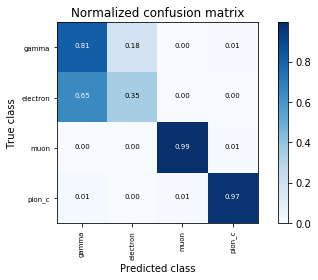

In [15]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(pid_array, pid_predicted)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(0)
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True, title='Normalized confusion matrix')
plt.savefig(plot_dir + model_name + 'confusion_matrix.pdf', format='pdf')
plt.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


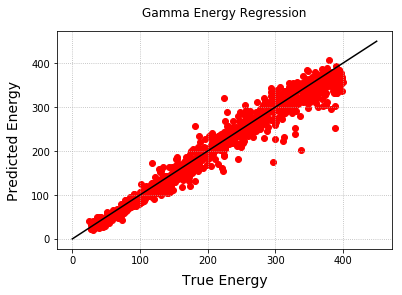

In [16]:
#gamma's energy
fig1 = plt.figure(1)
plt.scatter(gamma_true_en, gamma_reco_en, color='red')
plt.title('Gamma Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black')
plt.grid(linestyle=':')
plt.savefig(plot_dir + model_name + 'gammaEn.pdf', format='pdf')
fig1.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


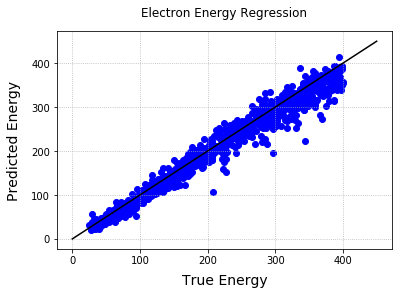

In [17]:
#electron's energy
fig2 = plt.figure(2)
plt.scatter(electron_true_en, electron_reco_en, color='blue')
plt.title('Electron Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black')
plt.grid(linestyle=':')
plt.savefig(plot_dir + model_name + 'electronEn.pdf', format='pdf')
fig2.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


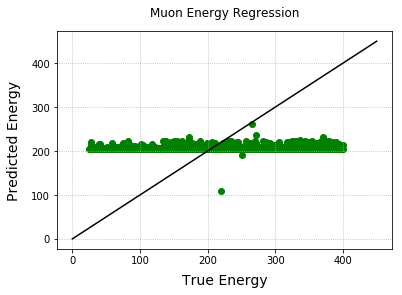

In [18]:
#muon's energy
fig3 = plt.figure(3)
plt.scatter(muon_true_en, muon_reco_en, color='green')
plt.title('Muon Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black')
plt.grid(linestyle=':')
plt.savefig(plot_dir + model_name + 'muonEn.pdf', format='pdf')
fig3.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


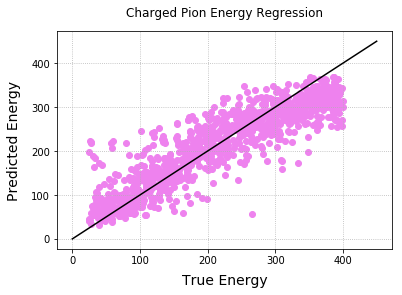

In [19]:
#pion_c's energy
fig4 = plt.figure(4)
plt.scatter(pion_c_true_en, pion_c_reco_en, color='violet')
plt.title('Charged Pion Energy Regression', y=1.04)
plt.xlabel('True Energy', labelpad=8, fontsize=14)
plt.ylabel('Predicted Energy', labelpad=10, fontsize=14)
plt.plot([0,450],[0,450], color='black')
plt.grid(linestyle=':')
plt.savefig(plot_dir + model_name + 'pion_cEn.pdf', format='pdf')
fig4.show()

In [20]:
file = pd.read_hdf(save_dir + history_name + ".h5", "history") #.values
print(file.head())

file = file.values

val_loss = file[:, 0]
val_pid_loss = file[:, 1]
val_en_loss = file[:,2]

val_pid_acc =file[:,3]

train_loss = file[:, 5]
train_pid_loss = file[:,6]
train_en_loss = file[:,7]

train_pid_acc = file[:, 8]

n_epochs = len(file)
n_epochs = np.arange(1, n_epochs+1)
print("Number of Epochs: ", n_epochs)

   val_loss  val_pid_output_loss  val_enreg_output_loss  val_pid_output_acc  \
0  0.886586             0.275588               0.305499            0.918611   
1  0.715225             0.205520               0.254853            0.940000   
2  0.724699             0.127663               0.298518            0.962222   
3  0.551696             0.108194               0.221751            0.968611   
4  0.564081             0.093562               0.235260            0.973611   

   val_enreg_output_mean_squared_error      loss  pid_output_loss  \
0                             0.305499  2.400285         1.052152   
1                             0.254853  1.249675         0.443580   
2                             0.298518  1.158068         0.424045   
3                             0.221751  1.126193         0.415102   
4                             0.235260  1.098724         0.409305   

   enreg_output_loss  pid_output_acc  enreg_output_mean_squared_error  
0           0.674066        0.467191  

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


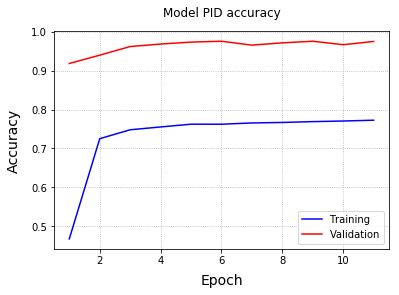

In [21]:
fig5 = plt.figure(5)
plt.plot(n_epochs, train_pid_acc, '-b', label='Training')
plt.plot(n_epochs, val_pid_acc, '-r', label='Validation')

plt.title('Model PID accuracy', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Accuracy', labelpad=10, fontsize=14)
plt.legend(loc='lower right')
plt.savefig(plot_dir + model_name + 'pid_accuracy.pdf', format='pdf')
fig5.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


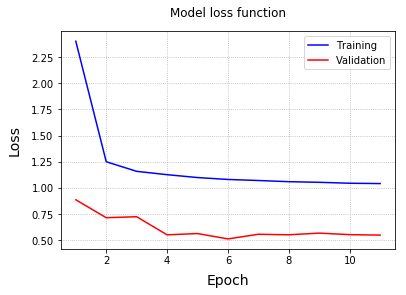

In [22]:
fig6 = plt.figure(6)
plt.plot(n_epochs, train_loss, '-b', label='Training')
plt.plot(n_epochs, val_loss, '-r', label='Validation')

plt.title('Model loss function', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
plt.savefig(plot_dir + model_name + 'total_loss.pdf', format='pdf')
fig6.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


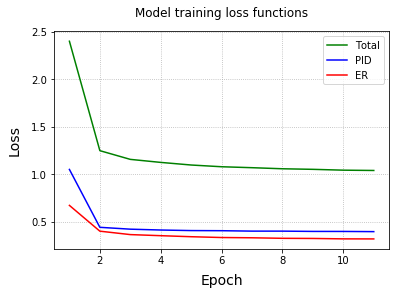

In [23]:
fig7 = plt.figure(7)
plt.plot(n_epochs, train_loss, '-g', label='Total')
plt.plot(n_epochs, train_pid_loss, '-b', label='PID')
plt.plot(n_epochs, train_en_loss, '-r', label='ER')


plt.title('Model training loss functions', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
plt.savefig(plot_dir + model_name + 'training_loss.pdf', format='pdf')
fig7.show()

/data/user/adipilat/anaconda3/lib/python3.6/site-packages/matplotlib/figure.py:459: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


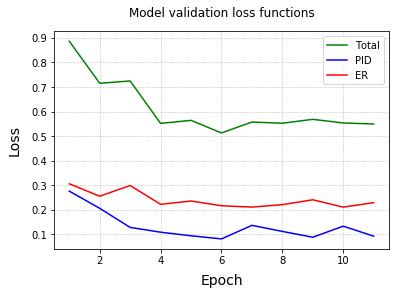

In [24]:
fig8 = plt.figure(8)
plt.plot(n_epochs, val_loss, '-g', label='Total')
plt.plot(n_epochs, val_pid_loss, '-b', label='PID')
plt.plot(n_epochs, val_en_loss, '-r', label='ER')


plt.title('Model validation loss functions', y=1.04)
plt.grid(linestyle=':')
plt.xlabel('Epoch', labelpad=8, fontsize=14)
plt.ylabel('Loss', labelpad=10, fontsize=14)
plt.legend(loc='upper right')
plt.savefig(plot_dir + 'validation_loss.pdf', format='pdf')
fig8.show()